In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [8]:
beta_x = np.random.normal(2, size=N) 
beta_x
#beta_z = 1. / 25
#beta_z

array([1.83034852, 0.45278639, 2.30086955, ..., 1.14239559, 0.93756787,
       0.15071424])

In [4]:
N = 365*20

beta_x = np.random.normal(2, size=N)  # E[\delta] = 2
beta_z = 1. / 25

z = np.random.normal(50, 10, size=N)
x = np.random.binomial(1, p=1/(1 + np.exp(-(z - z.mean())/z.std())))
y = np.random.poisson(beta_x*x + beta_z*z)

df = pd.DataFrame({'z': z, 'x': x, 'y': y})

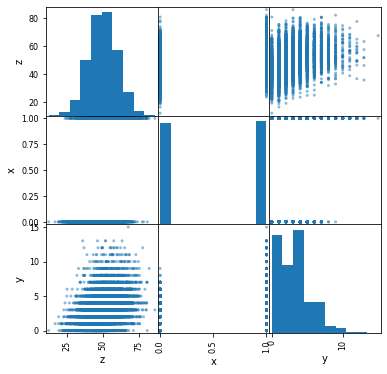

In [5]:
pd.plotting.scatter_matrix(df, figsize=(6,6));

In [ ]:
df.mean()

z    50.094596
x     0.492055
y     2.956164
dtype: float64

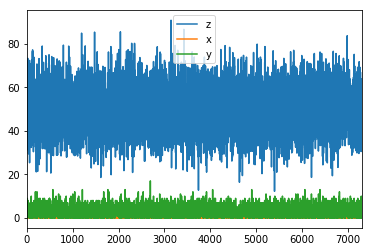

In [ ]:
df.plot()

In [ ]:
delta = df.groupby('x').mean()['y'][1] - df.groupby('x').mean()['y'][0]
delta

2.317548225350353

It looks biased, but we're dealing with relatively small sample sizes here. Let's bootstrap a confidence interval to be more certain.

In [ ]:
deltas = []
for _ in range(1000):
    sample_df = df.sample(n=len(df), replace=True).copy()
    delta = sample_df.groupby('x').mean()['y'][1] - sample_df.groupby('x').mean()['y'][0]
    deltas.append(delta)
deltas = pd.Series(deltas)

In [ ]:
# for a quick 95% confidence interval ...
deltas.mean() - 1.96* deltas.std(), deltas.mean() + 1.96* deltas.std()

(2.230157101288869, 2.4003514765624585)

So we're more sure that the naive estimator is biased.

We can estimate this same biased estimate with linear regression (and about the same confidence intervals!)

In [ ]:
from statsmodels.api import OLS


df['intercept'] = 1
model = OLS(endog=df['y'], 
            exog=df[['x', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     2759.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:35:12   Log-Likelihood:                -14984.
No. Observations:                7300   AIC:                         2.997e+04
Df Residuals:                    7298   BIC:                         2.999e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.3175      0.044     52.526      0.000       2.231       2.404
intercept      1.8158      0.031     58.668      0.000       1.755       1.876
==============================================================================
Omnibus:                      751.710   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1225.721
Skew:                           0.739   Prob(JB):                    6.89e-267
Kurtosis:                       4.358   Cond. No.                         2.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df['propensity_score'] = df['x'] * result.predict() + \
                         (1 - df['x']) * (1 - result.predict())df['propensity_score'] = df['x'] * result.predict() + \
                         (1 - df['x']) * (1 - result.predict())

In [ ]:
# here's our y-intercept
beta_z * df.groupby('x').mean()['z'][0]

1.8428065983224067

In [ ]:
# here's our bias in the regression coefficient
beta_z * (df.groupby('x').mean()['z'][1] - df.groupby('x').mean()['z'][0])

0.3271530926997673

We can do the same estimate using the correct link with GLM, since this is a Poisson outcome. 

In [ ]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Poisson

In [ ]:
df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'intercept']],
            family=Poisson(link=Poisson.links[1]()),
            link=Poisson.links[1]()  # identity link function!
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                     7298
Model Family:                 Poisson   Df Model:                            1
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14162.
Date:                Tue, 16 Feb 2021   Deviance:                       9267.9
Time:                        19:50:51   Pearson chi2:                 8.53e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.3175      0.041     57.221      0.000       2.238       2.397
intercept      1.8158      0.022     82.055      0.000       1.772       1.859
==============================================================================
"""

# Controlling for $Z$ as well.

In [ ]:
from statsmodels.api import OLS

df['intercept'] = 1
model = OLS(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]()),
            link=Poisson.links[1]()
           )
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     1544.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:17:26   Log-Likelihood:                -15016.
No. Observations:                7300   AIC:                         3.004e+04
Df Residuals:                    7297   BIC:                         3.006e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              2.0655      0.049     42.344      0.000       1.970       2.161
z              0.0361      0.002     15.022      0.000       0.031       0.041
intercept      0.1535      0.114      1.348      0.178      -0.070       0.377
==============================================================================
Omnibus:                      923.773   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1779.152
Skew:                           0.809   Prob(JB):                         0.00
Kurtosis:                       4.798   Cond. No.                         263.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Poisson

In [ ]:
df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]()),
            link=Poisson.links[1](),
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                     7297
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13964.
Date:                Tue, 16 Feb 2021   Deviance:                       8872.4
Time:                        19:52:11   Pearson chi2:                 8.10e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9863      0.044     45.126      0.000       1.900       2.073
z              0.0398      0.002     20.516      0.000       0.036       0.044
intercept     -0.0127      0.088     -0.145      0.885      -0.185       0.160
==============================================================================
"""

# Using the BDA directly

We relied on the trick that our model parameters give an estimator for $\delta$. Instead, we can use the fact that our linear model adjusting for $Z$ is an estimator for $E[Y|X, Z]$, and directly apply the back-door adjustment formula.

In [ ]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Poisson


df['intercept'] = 1
model = GLM(endog=df['y'], 
            exog=df[['x', 'z', 'intercept']],
            family=Poisson(link=Poisson.links[1]())
           )
result = model.fit()
result.summary()

/home/akelleh/.virtualenvs/data/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7300
Model:                            GLM   Df Residuals:                     7297
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13964.
Date:                Tue, 16 Feb 2021   Deviance:                       8872.4
Time:                        20:09:07   Pearson chi2:                 8.10e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9863      0.044     45.126      0.000       1.900       2.073
z              0.0398      0.002     20.516      0.000       0.036       0.044
intercept     -0.0127      0.088     -0.145      0.885      -0.185       0.160
==============================================================================
"""

We should find a value of around $\delta=2.07$.

The trick is that our observational $Z$ data is drawn from $P(Z)$. If we weight estimates of $E[Y|X, Z]$ by evaluating it one each data point and averaging, it's the same thing as taking a weighted average of stratum-level estimates weighting by $P(Z)$ -- but it works for continuous variables!

In [ ]:
df_1 = df.copy()  # We'll modify the dataframe, so create a copy to work with.
df_1

,z,x,y,intercept
0,31.322197,0,1,1
1,57.872975,1,5,1
2,65.175720,1,5,1
3,61.897224,1,4,1
4,47.774446,1,2,1
...,...,...,...,...
7295,32.212076,0,1,1
7296,48.194682,0,1,1
7297,47.999267,0,1,1
7298,54.256288,0,1,1


In [ ]:
df_1['x'] = 1     # enforce do(X=1) on the data, prior to prediction of E[Y|X=1, Z=z]
df_1

,z,x,y,intercept
0,31.322197,1,1,1
1,57.872975,1,5,1
2,65.175720,1,5,1
3,61.897224,1,4,1
4,47.774446,1,2,1
...,...,...,...,...
7295,32.212076,1,1,1
7296,48.194682,1,1,1
7297,47.999267,1,1,1
7298,54.256288,1,1,1


In [ ]:
df_1['y_pred_1'] = result.predict(exog=df_1[['x', 'z', 'intercept']]) # Estimate E[Y|X=1, Z=z]
df_1

,z,x,y,intercept,y_pred_1
0,31.322197,1,1,1,3.218761
1,57.872975,1,5,1,4.274308
2,65.175720,1,5,1,4.564635
3,61.897224,1,4,1,4.434295
4,47.774446,1,2,1,3.872833
...,...,...,...,...,...
7295,32.212076,1,1,1,3.254139
7296,48.194682,1,1,1,3.889540
7297,47.999267,1,1,1,3.881771
7298,54.256288,1,1,1,4.130524


In [ ]:
df_1.mean()['y_pred_1']

3.965072724898311

In [ ]:
df['y_pred_1'] = result.predict(exog=df_1[['x', 'z', 'intercept']]) # Estimate E[Y|X=1, Z=z]

In [ ]:
# repeat the above for do(X=0)
df_0 = df.copy()
df_0['x'] = 0
df['y_pred_0'] = result.predict(exog=df_0[['x', 'z', 'intercept']])

In [ ]:
(df['y_pred_1'] - df['y_pred_0']).mean()

1.986254285803078

In [ ]:
df['y_pred_0'].mean() # an estimate of E[Y|do(X=1)]

1.9788184390952521

In [ ]:
df['y_pred_1'].mean() # an estimate of E[Y|do(X=0)]

3.965072724898331

## This is much more powerful than a simple ATE estimator!

In [ ]:
# repeat the above for do(X=x)

x = 2.5

df_x = df.copy()
df_x['x'] = x
df['y_pred_x'] = result.predict(exog=df_x[['x', 'z', 'intercept']])
df['y_pred_x'].mean() # an estimate of E[Y|do(X=x)]

6.9444541536029485